# 1. Goal

**Goal:** to map customer journey with all online touch points which can be trackable.

- **Expected basetable:**
    + full_visitor_id 
    + organization_uuid 
    + session_info (id, start time, end time, traffic source, traffic medium, session_reached_minimum_created)
    + country_id
    + organization_created
    
    The basetable will be used for marketing attribution modelling.
    
    
- **Challenges:** 

GA data:
    1. Cookies depedency: merchants can or cann't use cookies upto REG (trackable?)
    2. Unable to track REG via app
    3. Missing client_id and uuid (some cases cannt record google_id = uuid event at registration)
    4. 1 visitor_id: many uuid (one of reasons: due to register via laptops in campaigns, laptops of resellers ...)
    5. Many visitor_id: one uuid (one of reasons: often clear cookies)
    6. One merchant can register >= 2 times
    7. Internal IP

Fb and Youtube data:
    - Aggregated data: no data at Fb user view/ click
    
- **Solutions:**
    + User campaign data: iZettle'w own tracking
    + App_installs
    + Registration_attempt
    + Customer attribution sources OR attribution funnel
    
    + Fb and Youtube: customer behaviour assumptions?


# 2. Customer journey mapping

## 2.1 Methodology

- **2 principles:**

    1. Missing organization_uuid: filled by joining with our own tracking campaign data at REG (client_id)
    2. All merchants that cannot be tracked by GA data (cookies) will be traced back for their last touch point by our own internal tracking data (Customer attribution sources or attribution funnel)
    
- **GA data cleaning**

dasda
...
...

- **Used datasets**
    + google_analytics_session (ga data)
    + user_campaign_data (own tracking campaign data)
    + customer_acquisition_source / attribution_funnel_traffic_source/ app_installs (?) (last touch point data)
    + organization_customer


## 2.2 Overview of used datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext google.cloud.bigquery

### 2.2.1 Google_analytics_session

In [238]:
%%bigquery df_REG
SELECT 
  COUNT(DISTINCT gas.organization_uuid)
  #, gas.full_visitor_id , gas.session_id , gas.session_start_time , gas.session_end_time , gas.session_reached_minimal_created 
FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` gas
JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
    ON oc.organization_uuid = gas.organization_uuid 
WHERE oc.organization_created >= session_start_time 
    AND session_reached_minimal_created IS True

In [239]:
%%bigquery df_to_REG
SELECT 
  COUNT(DISTINCT gas.organization_uuid)
  #, gas.full_visitor_id , gas.session_id , gas.session_start_time , gas.session_end_time , gas.session_reached_minimal_created 
FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` gas
JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
    ON oc.organization_uuid = gas.organization_uuid 
WHERE oc.organization_created >= session_start_time 

Number of REG merchants since 2017-09-01

In [242]:
%%bigquery df_track
SELECT 
  COUNT(DISTINCT gas.organization_uuid)
FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` gas

Number of REG merchants since 2017-09-01

In [243]:
%%bigquery reg
SELECT
    COUNT(DISTINCT organization_uuid)
FROM `izettle-dp-pipeline-prod.legacy_views.organization_customer`
WHERE organization_created >= '2017-09-01'

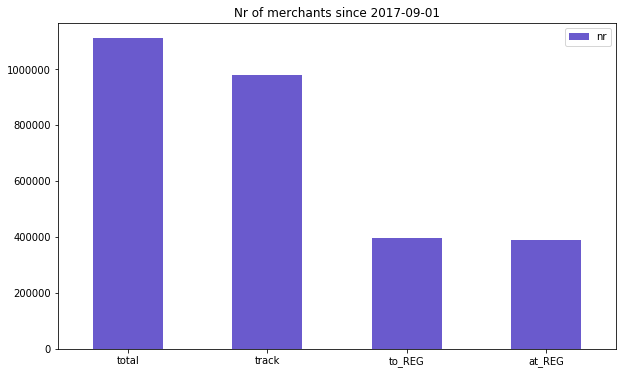

In [248]:
combine = pd.DataFrame(np.array([reg.iloc[0,0], df_track.iloc[0,0], df_to_REG.iloc[0,0], df_REG.iloc[0,0]]),
                  columns=['nr'], 
                  index = ['total', 'track', 'to_REG', 'at_REG'])
combine.plot(kind = 'bar', rot = 0, figsize=(10,6), color = 'slateblue',)
plt.title('Nr of merchants since 2017-09-01')
plt.show()

### 2.2.2 User_campaign_data

Built based on:
1. user_campaign_data_updated
2. user_profile_updated

### 2.2.3 Last touch point data

All of them are originated from organization_uuid to build!

Customer_acquisition_source dataset is built based on following datatables:
1. tag_comment
2. user_campaign and user_campaign_data (*)
3. retail_organization
4. sdk_organization and xero_organization
5. registration_attempt ('bank')

Attribution_funnel_traffic_source dataset is built based on following datatables:
1. app_installs
2. user_campaign and (user_campaign_data_updated and user_profile_updated)*
3. merchant_created (paypal source)

*Prefer: attribution_funnel_traffic (skd and xero) cuz GA cannt track REG via app install.* -> test!

Customer_acquisition_source

In [6]:
%%bigquery customer_acquisition
SELECT
    cas.organization_uuid,
    cas.channel_level_3,
    oc.organization_created,
    oc.country_id
FROM `izettle-dp-pipeline-prod.legacy_views.customer_acquisition_source` cas
JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer`oc
ON cas.organization_uuid = oc.organization_uuid
WHERE oc.organization_created >= '2017-09-01'

In [7]:
customer_acquisition.head()

,organization_uuid,channel_level_3,organization_created,country_id
0,caba6bc0-e0ca-11e7-8b0f-16a852e15726,ps_pay_sdk,2017-12-14 12:32:04.732000+00:00,IT
1,9ea4aac0-0cf6-11e8-a123-52100336edaa,ps_pay_sdk,2018-02-08 17:36:39.788000+00:00,IT
2,5fc8e8ce-2a60-11e9-9a35-3cd1e57583c4,ps_pay_sdk,2019-02-06 22:41:42.374000+00:00,IT
3,36bdfc66-76bf-11e9-846d-d2ad95cf63eb,ps_pay_sdk,2019-05-15 03:12:04.076000+00:00,IT
4,dfaef250-9009-11e8-aad8-27ce3c467d03,ps_pay_sdk,2018-07-25 12:54:31.669000+00:00,IT


In [8]:
customer_acquisition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110000 entries, 0 to 1109999
Data columns (total 4 columns):
organization_uuid       1110000 non-null object
channel_level_3         1110000 non-null object
organization_created    1110000 non-null datetime64[ns, UTC]
country_id              1110000 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 33.9+ MB


In [11]:
print('NameErrorr of merchants:',customer_acquisition.organization_uuid.nunique())
print('Traffic source levels:', customer_acquisition.channel_level_3.unique())

NameErrorr of merchants: 1110000
Traffic source levels: ['ps_pay_sdk' 'o_paid_sem' 'o_paid_social' 'o_paid_affiliate'
 'ps_bank_bank' 'ps_other_retail' 'ps_other_partner'
 'ps_other_local_partnership' 'o_organic_seo' 'o_organic_null'
 'o_organic_direct' 'o_organic_invite' 'o_organic_referral'
 'ds_inbound_inbound' 'ds_keyaccount_keyaccount' 'ps_product_api'
 'o_paid_app_install' 'ds_keyaccount_sdk']


In [12]:
traffic_change = {'ps':['ps_pay_sdk','ps_bank_bank','ps_other_retail', 'ps_other_partner', 'ps_other_local_partnership', 'ps_product_api'],
                 'ds':['ds_inbound_inbound','ds_keyaccount_keyaccount','ds_keyaccount_sdk']}

In [35]:
def change(x):
    if x in list(traffic_change.values())[0]: return list(traffic_change.keys())[0] 
    elif x in list(traffic_change.values())[1]: return list(traffic_change.keys())[1]
    else: return x

In [37]:
customer_acquisition['traffic_source'] = customer_acquisition['channel_level_3'].apply(change)

In [114]:
customer_acquisition_group = pd.DataFrame(customer_acquisition.groupby('traffic_source')['organization_uuid'].count())
customer_acquisition_group.rename(columns={'organization_uuid':'nr_merchants'}, inplace = True)
customer_acquisition_group.reset_index(inplace = True)

customer_acquisition_group['pert'] = customer_acquisition_group['nr_merchants']/customer_acquisition.shape[0] 

Attribution_funnel

In [152]:
%%bigquery attribution_funnel
SELECT
    af.organization_uuid,
    af.traffic_source_level_3,
    oc.organization_created,
    oc.country_id
FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer`oc
ON af.organization_uuid = oc.organization_uuid
WHERE oc.organization_created >= '2017-09-01'

In [153]:
attribution_funnel.head()

,organization_uuid,traffic_source_level_3,organization_created,country_id
0,25cb1a20-1ca1-11e8-b63d-65624675a7bb,ds_inbound_inbound,2018-02-28 16:05:08.418000+00:00,IT
1,5ac103a0-1c8f-11e8-9451-d9280659f68d,ds_inbound_inbound,2018-02-28 13:57:46.330000+00:00,IT
2,97b07ae0-d061-11e7-9b40-ed96a943ff4c,ds_inbound_inbound,2017-11-23 15:18:43.342000+00:00,IT
3,8d243380-d0fe-11e7-8e34-7d89207b4112,ds_inbound_inbound,2017-11-24 10:02:16.632000+00:00,IT
4,bdee4a60-db70-11e7-a393-f8f3adae0c08,ds_inbound_inbound,2017-12-07 17:04:52.742000+00:00,IT


In [154]:
attribution_funnel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110000 entries, 0 to 1109999
Data columns (total 4 columns):
organization_uuid         1110000 non-null object
traffic_source_level_3    1110000 non-null object
organization_created      1110000 non-null datetime64[ns, UTC]
country_id                1110000 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 33.9+ MB


In [155]:
print('NameErrorr of merchants:',attribution_funnel.organization_uuid.nunique())
print('Traffic source levels:', attribution_funnel.traffic_source_level_3.unique())

NameErrorr of merchants: 1110000
Traffic source levels: ['ds_inbound_inbound' 'ds_keyaccount_keyaccount' 'ps_other_partner'
 'o_paid_sem' 'ps_bank_bank' 'o_organic_app' 'o_organic_seo'
 'o_paid_social' 'o_organic_null' 'o_organic_direct' 'o_organic_invite'
 'o_paid_affiliate' 'o_organic_referral' 'o_paid_app_install'
 'ps_other_local_partnership' 'ps_other_isc' 'pp_paypal_paypal'
 'ps_product_api' 'ps_pay_sdk' 'ds_keyaccount_sdk']


In [156]:
traffic_change_2 = {'ps':['ps_pay_sdk','ps_bank_bank','ps_other_retail', 'ps_other_partner', 'ps_other_local_partnership', 'ps_product_api', 'ps_other_isc', 'pp_paypal_paypal'],
                 'ds':['ds_inbound_inbound','ds_keyaccount_keyaccount','ds_keyaccount_sdk']}

In [157]:
def change_2(x):
    if x in list(traffic_change_2.values())[0]: return list(traffic_change.keys())[0] 
    elif x in list(traffic_change_2.values())[1]: return list(traffic_change.keys())[1]
    else: return x

In [159]:
attribution_funnel['traffic_source'] = attribution_funnel['traffic_source_level_3'].apply(change_2)

In [186]:
attribution_funnel_group = pd.DataFrame(attribution_funnel.groupby('traffic_source')['organization_uuid'].count())
attribution_funnel_group.rename(columns={'organization_uuid':'nr_merchants'}, inplace = True)
attribution_funnel_group.reset_index(inplace = True)

attribution_funnel_group['pert'] = attribution_funnel_group['nr_merchants']/attribution_funnel.shape[0] 

In [187]:
merge_attribution = attribution_funnel_group.merge(customer_acquisition_group, how = 'left', on = 'traffic_source')
merge_attribution.rename(columns={'pert_x':'pert_attribution_funnel', 'pert_y':'pert_customer_acquisition'}, inplace=True)
merge_attribution = merge_attribution[['traffic_source', 'pert_attribution_funnel','pert_customer_acquisition']] = merge_attribution[['traffic_source', 'pert_attribution_funnel','pert_customer_acquisition']]

In [197]:
merge_attribution_t = merge_attribution.transpose()
merge_attribution_t.columns = merge_attribution_t.iloc[0,]
merge_attribution_t.drop(['traffic_source'], inplace=True)
merge_attribution_t

traffic_source,ds,o_organic_app,o_organic_direct,o_organic_invite,o_organic_null,o_organic_referral,o_organic_seo,o_paid_affiliate,o_paid_app_install,o_paid_sem,o_paid_social,ps
pert_attribution_funnel,0.0235378,0.100436,0.133275,0.0126018,0.141261,0.0151117,0.101787,0.0619856,0.0143369,0.279918,0.0536216,0.062127
pert_customer_acquisition,0.0248108,NaN,0.124617,0.0124387,0.250965,0.0158937,0.0986874,0.0615892,0.000157658,0.27417,0.0519865,0.0846838


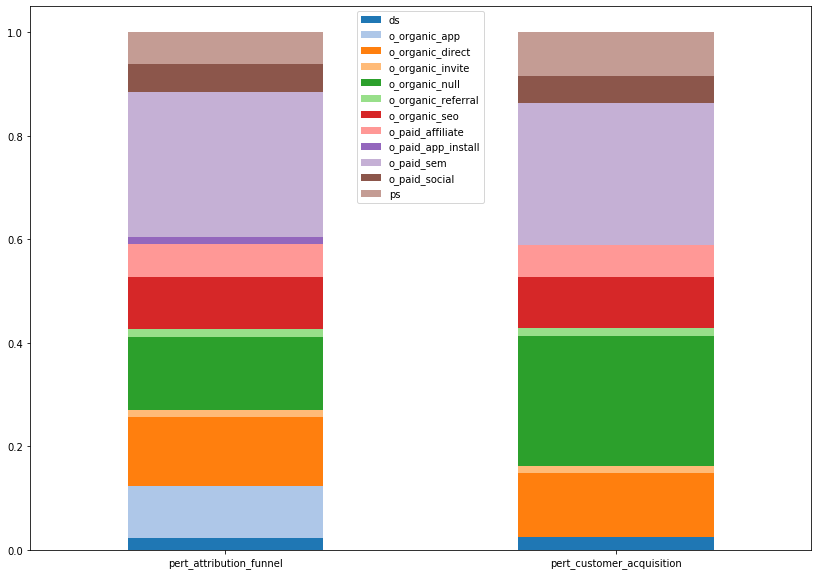

In [202]:
pal = sns.color_palette("tab20")
merge_attribution_t.plot(kind = 'bar', stacked = True,
                  rot = 0, color = pal,
                  figsize = (14,10))

plt.legend(loc = 'upper center')
plt.show()

1. Increase in o_paid_app_install in attribution_funnel (0.0144 - 0.0001)
2. Organic_null in customer_acquisition >> Organic_null in attribution_funnel:

    => compensate by o_organic_app in attribution_funnel
    
    => main diff: in APP REG tracking
    
**So: pick attribution_funnel**

In [209]:
attribution_funnel_group

,traffic_source,nr_merchants,pert
0,ds,26127,0.023538
1,o_organic_app,111484,0.100436
2,o_organic_direct,147935,0.133275
3,o_organic_invite,13988,0.012602
4,o_organic_null,156800,0.141261
5,o_organic_referral,16774,0.015112
6,o_organic_seo,112984,0.101787
7,o_paid_affiliate,68804,0.061986
8,o_paid_app_install,15914,0.014337
9,o_paid_sem,310709,0.279918


app_installs

In [207]:
%%bigquery app_installs
SELECT 
 installed_at , source  , country_id , organization_uuid , organization_created 
FROM `izettle-dp-pipeline-prod.legacy_views.app_installs` 
WHERE organization_created >= '2017-09-01'
AND organization_created >= installed_at 
AND source IN ('organic', 'paid')

#total number of possible merchants that registered via app. Actual should <. 

In [208]:
app_installs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147107 entries, 0 to 147106
Data columns (total 5 columns):
installed_at            147107 non-null datetime64[ns, UTC]
source                  147107 non-null object
country_id              147107 non-null object
organization_uuid       147107 non-null object
organization_created    147107 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), object(3)
memory usage: 5.6+ MB


In [206]:
app_installs.head()

,installed_at,source,country_id,organization_uuid,organization_created
0,2019-01-27 04:41:38+00:00,paid,et,23af95ec-21ee-11e9-9100-9b35b3730c90,2019-01-27 04:43:49.615000+00:00
1,2019-01-27 19:22:42+00:00,organic,us,21f67ef2-2269-11e9-bf05-e17c28c9406b,2019-01-27 19:24:14.822000+00:00
2,2018-01-27 03:12:05+00:00,organic,us,9dcaadc6-4b33-11e9-9920-403bf22f6918,2019-03-20 17:14:27.423000+00:00
3,2018-01-27 12:47:32+00:00,organic,it,b7857280-0360-11e8-b7c6-bfd1996c4125,2018-01-27 12:50:56.552000+00:00
4,2018-01-27 00:49:09+00:00,organic,us,1ddbc900-c277-11e8-9531-b631107d6328,2018-09-27 17:02:29.264000+00:00


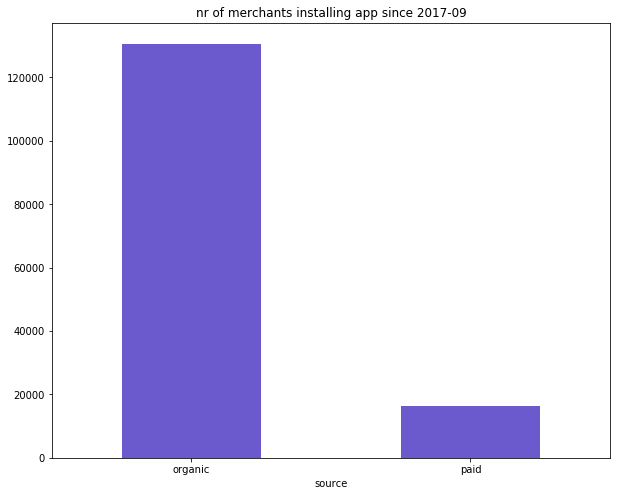

In [214]:
app_installs.groupby('source')['organization_uuid'].count().plot(kind = 'bar', color = 'slateblue',
                                                                rot = 0, figsize = (10,8))
plt.title('nr of merchants installing app since 2017-09')
plt.show()

### 2.2.4 Organization_customer

In [215]:
%%bigquery organization_customer
SELECT
    organization_uuid, organization_created, country_id
FROM `izettle-dp-pipeline-prod.legacy_views.organization_customer` 
WHERE organization_created >= '2017-09-01'

In [216]:
organization_customer.head()

,organization_uuid,organization_created,country_id
0,018781f0-91b7-11e7-a558-77558f88ab82,2017-09-04 21:21:24.879000+00:00,BR
1,2a7e1d50-90e8-11e7-b3e5-b2cc40d34d1f,2017-09-03 20:40:47.781000+00:00,ES
2,c9fc6e60-8ff6-11e7-8cee-3d05611a4a8b,2017-09-02 15:52:57.158000+00:00,NL
3,89dee6f0-a374-11e7-a731-7d53bf343a24,2017-09-27 11:10:58.271000+00:00,NL
4,a00942c0-93b3-11e7-b57c-5bec2f72449f,2017-09-07 10:02:15.148000+00:00,NL


In [230]:
organization_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110000 entries, 0 to 1109999
Data columns (total 3 columns):
organization_uuid       1110000 non-null object
organization_created    1110000 non-null datetime64[ns, UTC]
country_id              1110000 non-null object
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 25.4+ MB


In [225]:
country_group = pd.DataFrame(organization_customer.groupby('country_id')['organization_uuid'].count())

In [227]:
country_group.rename(columns= {'organization_uuid':'nr_uuid'}, inplace = True)
country_group.sort_values('nr_uuid')

,nr_uuid
country_id,
AI,1
GS,1
GT,1
HN,1
HR,1
...,...
NL,69175
FR,75013
MX,212904


In [229]:
main_countries = country_group[country_group['nr_uuid'] > 100]
main_countries

,nr_uuid
country_id,
BR,219229
DE,51663
DK,15790
ES,12619
FI,34510
FR,75013
GB,329369
IT,5248
MX,212904


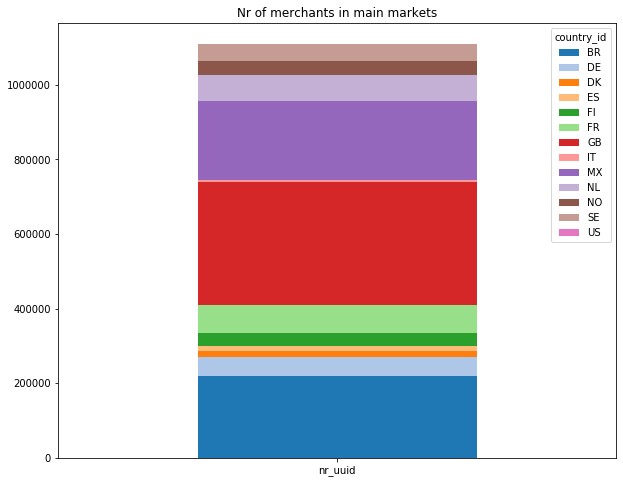

In [236]:
pal = sns.color_palette("tab20")
main_countries_t = main_countries.transpose()
#main_countries_t.columns = main_countries.iloc[0,]
main_countries_t.plot.bar(stacked = True, color = pal,
                         rot = 0, figsize = (10,8))
plt.title('Nr of merchants in main markets')
plt.show()

## 2.3 SQL code

In [253]:
%%bigquery df

WITH clean AS 
(
SELECT 
  DISTINCT full_visitor_id , client_id , organization_uuid , country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created , 
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  COUNT(DISTINCT organization_uuid) OVER(PARTITION BY full_visitor_id ) as nr_unique_uuid
FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
WHERE full_visitor_id NOT IN (--list of visitor id that has no client id and only one unique (NA) uuid and 
                          SELECT
                              full_visitor_id 
                          FROM (
                                SELECT
                                    DISTINCT full_visitor_id , client_id , organization_uuid  ,
                                    DENSE_RANK() OVER(PARTITION BY full_visitor_id ORDER BY client_id DESC, organization_uuid DESC) as rank_entry 
                                    #optimize the code by group by and array_agg()?
                                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                WHERE full_visitor_id IN (SELECT 
                                                            DISTINCT full_visitor_id
                                                          FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                                          WHERE client_id IS NULL AND organization_uuid IS NULL
                                                          )
                                #ORDER BY full_visitor_id , rank_entry
                                      )
                          WHERE rank_entry = 1
                          AND client_id IS NULL
                          AND organization_uuid IS NULL
                          ) 
), 
ga_processed AS (
--delete row with no uuid and nr_unique_uuid per group of visitor id of that row > 1 
-- and fill NA uuid cells (Expected: rows with NA uuid and nr_unique_uuid =0 left)--
SELECT 
  full_visitor_id , client_id , organization_uuid , 
  IFNULL(organization_uuid, MAX(organization_uuid) OVER(PARTITION BY full_visitor_id)) as fill_uuid ,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  nr_unique_uuid
FROM clean
WHERE 
  organization_uuid IS NOT NULL
  #OR
  #(organization_uuid IS NULL  
  #AND nr_unique_uuid = 0 AND client_id IS NOT NULL) 
  OR
  (organization_uuid IS NULL AND nr_unique_uuid <= 1)
),
merged_campaign AS(
SELECT
  full_visitor_id , 
  IFNULL(fill_uuid, MAX(campaign_data.organization_uuid) OVER(PARTITION BY client_id)) as fill_uuid_2,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3, traffic_source_source, traffic_source_medium
FROM ga_processed
LEFT JOIN (SELECT
              DISTINCT google_analytics_id , organization_uuid 
           FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
           WHERE google_analytics_id IN (
                                         SELECT DISTINCT google_analytics_id
                                         FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
                                         GROUP BY google_analytics_id 
                                         HAVING COUNT(DISTINCT organization_uuid) = 1
                                         ) 
          ) AS campaign_data
ON ga_processed.client_id = campaign_data.google_analytics_id 
),
merged_oc AS (
--customer journey of merchants until registration tracked by ga cookies--
--only ~ 245,000 merchants have the recorded journey. The rest that we have only the last touch point can be found in the customer_acquisition table--
SELECT
  ft.fill_uuid_2 as organization_uuid , oc.organization_created ,
  ft.full_visitor_id, ft.country_id , ft.session_id , ft.session_start_time , ft.session_end_time ,
  ft.session_reached_minimal_created ,
  ft.traffic_source_level_3,
  traffic_source_source, traffic_source_medium
FROM merged_campaign ft
LEFT JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON ft.fill_uuid_2 =oc.organization_uuid 
WHERE fill_uuid_2 IS NOT NULL
AND oc.organization_created >= ft.session_start_time 
)
SELECT
  uuid_left.organization_uuid ,
  uuid_left.organization_created ,
  uuid_left.traffic_source_level_3 as traffic_source_level_3_af ,
  merged_oc.full_visitor_id, merged_oc.country_id , merged_oc.session_id , merged_oc.session_start_time , merged_oc.session_end_time ,
  merged_oc.session_reached_minimal_created ,
  merged_oc.traffic_source_level_3,
  merged_oc.traffic_source_source, merged_oc.traffic_source_medium,
  IFNULL(merged_oc.traffic_source_level_3, uuid_left.traffic_source_level_3) as traffic_source_full
FROM (
      SELECT 
        af.organization_uuid,
        af.traffic_source_level_3 , oc.organization_created 
      FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
      JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
      ON af.organization_uuid = oc.organization_uuid 
      AND oc.organization_created >= '2017-09-01'
      ) as uuid_left
LEFT JOIN merged_oc
ON uuid_left.organization_uuid = merged_oc.organization_uuid 

In [254]:
df.head()

,organization_uuid,organization_created,traffic_source_level_3_af,full_visitor_id,country_id,session_id,session_start_time,session_end_time,session_reached_minimal_created,traffic_source_level_3,traffic_source_source,traffic_source_medium,traffic_source_full
0,1e106bf0-17f1-11e8-be14-cf477ffc3bb5,2018-02-22 16:54:59.375000+00:00,ps_other_isc,5574901013816178020,MX,"b'\xc0\xc8/\xe7\xbe""\x14\xe9p\xbax\xf2+v\xb7\x...",2018-02-07 13:48:26+00:00,2018-02-07 14:01:10+00:00,True,ds_inbound_inbound,local_inbound,(not set),ds_inbound_inbound
1,1e106bf0-17f1-11e8-be14-cf477ffc3bb5,2018-02-22 16:54:59.375000+00:00,ps_other_isc,5574901013816178020,MX,b'\xc5\xb3n\xedFY\x0800\xb3\xec\xa8\xd9!H\xe1\...,2018-02-07 03:41:23+00:00,2018-02-07 03:41:23+00:00,False,ds_inbound_inbound,local_inbound,(not set),ds_inbound_inbound
2,43eed460-d061-11e7-aab6-863e38f2d7ca,2017-11-23 15:16:22.822000+00:00,ds_inbound_inbound,1908932833655055913,GB,"b'\xdcd\x1eC^\x14\x8a""\x96\x8d\x16\xcf\xe1{\xd...",2017-11-23 15:15:49+00:00,2017-11-23 15:24:47+00:00,True,ds_inbound_inbound,local_inbound,inhouse,ds_inbound_inbound
3,eb811e20-b9bb-11e7-a653-148c2b3db96e,2017-10-25 19:37:21.922000+00:00,ds_inbound_inbound,3894070871094716620,MX,b'\x9c&<\xc7\xc4t;t<\xfc\x8c\xe5\xeb\xd0/>\xf2...,2017-10-25 18:27:52+00:00,2017-10-25 19:42:44+00:00,True,ds_inbound_inbound,local_inbound,(not set),ds_inbound_inbound
4,3b6b46a0-bd11-11e8-9112-a7c012d5c815,2018-09-20 20:10:34.378000+00:00,ds_inbound_inbound,2414604952915537359,MX,b'\x0b\xe3\xeeo!\x0f\x19%G\t\xfe\xcd\x00\x94\x...,2018-09-20 19:07:40+00:00,2018-09-20 20:19:48+00:00,True,ds_inbound_inbound,local_inbound,(not set),ds_inbound_inbound


In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697197 entries, 0 to 1697196
Data columns (total 13 columns):
organization_uuid                  object
organization_created               datetime64[ns, UTC]
traffic_source_level_3_af          object
full_visitor_id                    object
country_id                         object
session_id                         object
session_start_time                 object
session_end_time                   object
session_reached_minimal_created    object
traffic_source_level_3             object
traffic_source_source              object
traffic_source_medium              object
traffic_source_full                object
dtypes: datetime64[ns, UTC](1), object(12)
memory usage: 168.3+ MB


# 3. Validity check

In [257]:
df['organization_uuid'].nunique()

1110000

Number of unique uuid: 111,000 - match with the figure in organization_customer

## 3.1 Number of merchants by GA and attribution funnel|

In [259]:
merchant_ga = df[~df['session_id'].isna()]['organization_uuid'].nunique()

In [261]:
merchant_af = df[df['session_id'].isna()]['organization_uuid'].nunique()

In [264]:
pd.DataFrame({'nr':[merchant_ga, merchant_af]})

,nr
0,686630
1,423370


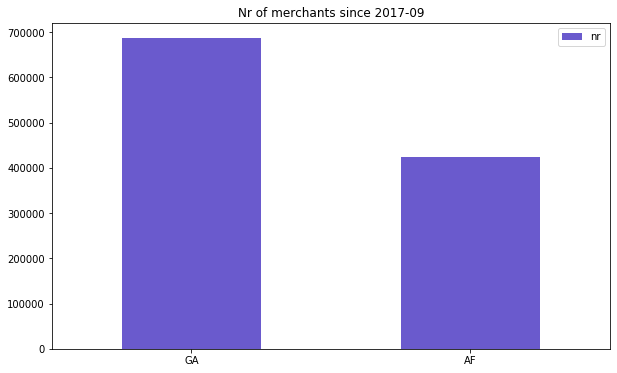

In [273]:
pd.DataFrame({'nr':[merchant_ga, merchant_af]}).plot(kind = 'bar', 
                                                     color = 'slateblue', 
                                                     rot = 0,
                                                    figsize = (10,6))
plt.xticks(ticks=[0,1], labels=('GA','AF'))
plt.title('Nr of merchants since 2017-09')
plt.show()

## 3.2 Number of merchants by traffic sources for uuid from attribution_funnel

In [277]:
df_af = df[df['session_id'].isna()]
df_af['traffic_source_level_3_af'] = df_af['traffic_source_level_3_af'].apply(change_2)
df_af.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,organization_uuid,organization_created,traffic_source_level_3_af,full_visitor_id,country_id,session_id,session_start_time,session_end_time,session_reached_minimal_created,traffic_source_level_3,traffic_source_source,traffic_source_medium,traffic_source_full
8787,4641d010-fbda-11e7-a729-cd0efb868181,2018-01-17 23:00:55.825000+00:00,ps,None,None,None,NaT,NaT,None,None,None,None,ps_other_isc
8788,aeb98070-9249-11e7-8ab1-2999443815a8,2017-09-05 14:51:21.975000+00:00,ps,None,None,None,NaT,NaT,None,None,None,None,ps_other_isc
8789,18ef7a22-b498-11e9-800b-e2fde8b0ed12,2019-08-01 20:08:15.788000+00:00,ps,None,None,None,NaT,NaT,None,None,None,None,ps_other_isc
8790,37beabb0-ed1c-11e8-8599-b9be388aabe5,2018-11-20 23:30:08.491000+00:00,ps,None,None,None,NaT,NaT,None,None,None,None,ps_other_isc
8791,d60e4d60-adef-11e7-89c6-07db3e6747bf,2017-10-10 19:18:45.814000+00:00,ps,None,None,None,NaT,NaT,None,None,None,None,ps_other_isc


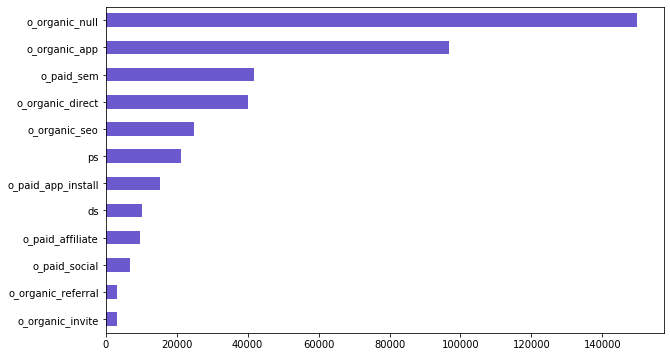

In [289]:
df_af_group = df_af.groupby('traffic_source_level_3_af')['organization_uuid'].nunique()
df_af_group.sort_values().plot(kind = 'barh', color = 'slateblue', rot = 0, figsize = (10,6))
plt.ylabel('')
plt.show()

Main contributors:
- o_organic_null: dont know the source
- app (organic and paid): as expected cuz GA cannot track REG via app

*And compare with app_install*

In [299]:
overlap_app = df_af[df_af['organization_uuid'].isin(app_installs['organization_uuid'].unique())]
overlap_app.shape[0]

105597

In [305]:
overlap_app_df = pd.DataFrame(overlap_app.groupby('traffic_source_level_3_af')['organization_uuid'].nunique())
overlap_app_df.rename(columns = {'organization_uuid':'nr_merchants'}, inplace = True)
overlap_app_df['per'] = overlap_app_df['nr_merchants']/overlap_app_df['nr_merchants'].sum()

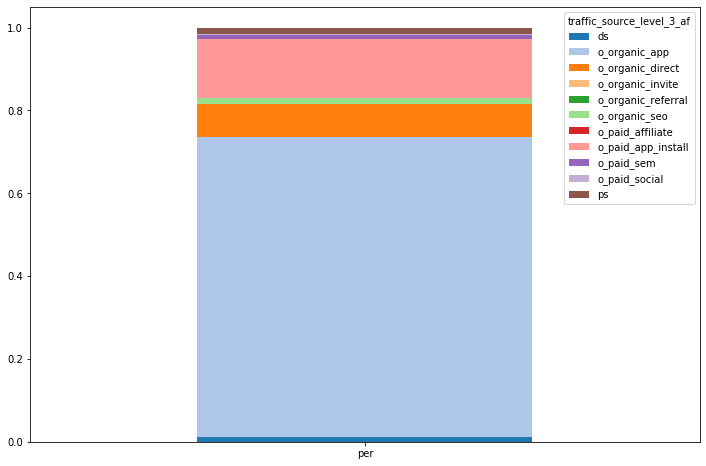

In [313]:
overlap_app_df[['per']].transpose().plot.bar(stacked = True,
                                            color = pal,
                                            figsize = (12,8), rot = 0)
plt.show()

As expected, most of overlapped uuid have the traffic source from App install. 

## 3.3 Last touch point before REG

In [314]:
df_ga = df[~df['session_id'].isna()]

In [316]:
df_ga[df_ga['session_reached_minimal_created'] == True]['organization_uuid'].nunique()

647695

In [317]:
merchant_af + 647695

1071065

In [318]:
1110000 - 1071065

38935

Missing 38935 (3%) last touch points?

- Cuz user_campaign_data also does not cover enought all unique uuid 
- and possibly a customer used cookies before REG and then did not use cookies at REG. 
- Or use cookies at REG but NA client_id and uuid. 

Solution:
take the last touch point from attribution_funnel

## 3.4 Unmatching between traffic_source_level_3_af and traffic_source_level_3

In [324]:
last_touch = df_ga[df_ga['session_reached_minimal_created'] == True]

In [325]:
unmatch = last_touch[last_touch['traffic_source_level_3_af'] != last_touch['traffic_source_full']]

In [331]:
unmatch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57639 entries, 0 to 1697175
Data columns (total 13 columns):
organization_uuid                  57639 non-null object
organization_created               57639 non-null datetime64[ns, UTC]
traffic_source_level_3_af          57639 non-null object
full_visitor_id                    57639 non-null object
country_id                         57635 non-null object
session_id                         57639 non-null object
session_start_time                 57639 non-null object
session_end_time                   57639 non-null object
session_reached_minimal_created    57639 non-null object
traffic_source_level_3             57639 non-null object
traffic_source_source              57639 non-null object
traffic_source_medium              57639 non-null object
traffic_source_full                57639 non-null object
dtypes: datetime64[ns, UTC](1), object(12)
memory usage: 6.2+ MB


In [330]:
unmatch['traffic_source_level_3_af'] = unmatch['traffic_source_level_3_af'].apply(change_2)
unmatch['traffic_source_level_3'] = unmatch['traffic_source_level_3'].apply(change_2)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [337]:
unmatch_group = unmatch.groupby('traffic_source_level_3_af')['traffic_source_level_3'].value_counts().unstack()

In [336]:
unmatch.groupby('traffic_source_level_3_af')['traffic_source_level_3'].value_counts().unstack()

traffic_source_level_3,ds,o_organic_direct,o_organic_invite,o_organic_null,o_organic_referral,o_organic_seo,o_paid_affiliate,o_paid_sem,o_paid_social,ps
traffic_source_level_3_af,,,,,,,,,,
ds,8.0,125.0,17.0,194.0,27.0,153.0,36.0,322.0,20.0,12.0
o_organic_app,23.0,342.0,35.0,2400.0,166.0,248.0,169.0,596.0,235.0,117.0
o_organic_direct,18.0,NaN,18.0,105.0,374.0,499.0,133.0,1496.0,257.0,122.0
o_organic_invite,1.0,22.0,NaN,2.0,15.0,13.0,5.0,28.0,1.0,2.0
o_organic_null,9.0,233.0,34.0,NaN,73.0,120.0,55.0,347.0,478.0,108.0
o_organic_referral,9.0,1073.0,4.0,47.0,NaN,260.0,28.0,283.0,49.0,24.0
o_organic_seo,88.0,908.0,20.0,66.0,629.0,NaN,324.0,778.0,30.0,143.0
o_paid_affiliate,2.0,86.0,9.0,7.0,101.0,124.0,NaN,242.0,19.0,6.0
o_paid_app_install,1.0,12.0,125.0,28.0,2.0,4.0,7.0,16.0,91.0,NaN


In [1]:
25000/1110000

0.02252252252252252